<a href="https://colab.research.google.com/github/minhaz1172/BME_PROJECT/blob/main/Seizure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 0: Install / imports
# =========================
!pip install mne --quiet
!pip install wfdb --quiet
!apt-get update -qq
!apt-get install -y -qq aria2  # for fast parallel download

import os, urllib.request, math, time
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Ensure GPU is visible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 139.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package li

In [ ]:
# CONFIG: subjects & files
# =========================
base_dir = "/content/chbmit_data"
os.makedirs(base_dir, exist_ok=True)
physionet_url = "https://physionet.org/files/chbmit/1.0.0/"

seizure_files = {
    'chb01': ['chb01_03.edf'],
    'chb05': ['chb05_04.edf'],
    'chb10': ['chb10_03.edf']
}

In [ ]:
# Build a small "urls.txt" and call aria2c with concurrency.
urls_txt = os.path.join(base_dir, "urls.txt")
with open(urls_txt, "w") as fh:
    for subj, files in seizure_files.items():
        for f in files:
            url = physionet_url + subj + "/" + f
            outdir = os.path.join(base_dir, subj)
            os.makedirs(outdir, exist_ok=True)
            outpath = os.path.join(outdir, f)

            fh.write(f"{url}\n")

print("Starting parallel download (aria2c). If files already exist, aria2c will skip them.")
# Call aria2c: 3 connections per server, 16 parallel downloads, continue mode
!aria2c -i /content/chbmit_data/urls.txt -x 16 -s 16 -k 1M -d /content/chbmit_data -j 8 --retry-wait=5 --max-tries=5

Starting parallel download (aria2c). If files already exist, aria2c will skip them.

12/05 06:50:45 [NOTICE] Downloading 3 item(s)
 *** Download Progress Summary as of Fri Dec  5 06:51:45 2025 *** 
=
[#8e2829 2.0MiB/40MiB(5%) CN:16 DL:34KiB ETA:18m55s]
FILE: /content/chbmit_data/chb01_03.edf
-
[#2acaa0 24MiB/40MiB(61%) CN:16 DL:443KiB ETA:35s]
FILE: /content/chbmit_data/chb05_04.edf
-
[#ff8cac 2.0MiB/80MiB(2%) CN:16 DL:36KiB ETA:37m6s]
FILE: /content/chbmit_data/chb10_03.edf
-

 *** Download Progress Summary as of Fri Dec  5 06:52:46 2025 *** 
=
[#8e2829 11MiB/40MiB(28%) CN:16 DL:299KiB ETA:1m39s]
FILE: /content/chbmit_data/chb01_03.edf
-
[#2acaa0 37MiB/40MiB(92%) CN:3 DL:0B]
FILE: /content/chbmit_data/chb05_04.edf
-
[#ff8cac 6.8MiB/80MiB(8%) CN:16 DL:127KiB ETA:9m53s]
FILE: /content/chbmit_data/chb10_03.edf
-


12/05 06:53:40 [NOTICE] Download complete: /content/chbmit_data/chb05_04.edf
 *** Download Progress Summary as of Fri Dec  5 06:53:46 2025 *** 
=
[#8e2829 18MiB/40MiB(46%) CN:1

In [7]:
# STEP 2: If aria2c failed for any file, fallback to urllib (single-file)
# =========================
for subj, files in seizure_files.items():
    subj_dir = os.path.join(base_dir, subj)
    for f in files:
        out_path = os.path.join(subj_dir, f)
        if not os.path.exists(out_path):
            url = physionet_url + subj + "/" + f
            print("Fallback downloading:", url)
            urllib.request.urlretrieve(url, out_path)


Fallback downloading: https://physionet.org/files/chbmit/1.0.0/chb10/chb10_03.edf


In [8]:
# STEP 3: Provide accurate seizure annotations for chosen files

seizure_annotations = {
    'chb01': {'chb01_03.edf': [(246,262)]},
    'chb05': {'chb05_04.edf': [(135,154)]},
    'chb10': {'chb10_03.edf': [(107,133)]}
}

In [9]:
# STEP 4: Extract 4-second windows (50% overlap) & labels
# =========================
fs = 256
win_sec = 4
win_samp = win_sec * fs
stride = win_samp // 2  # 50% overlap

def extract_windows_from_signal(signal, seizure_intervals, fs=256, win_samp=1024, stride=512, exclude_margin_s=30):
    """
    signal: np.array shape (n_channels, n_samples)
    seizure_intervals: list of (start_s, end_s)
    returns: windows (N, timesteps, channels), labels (N,)
    """
    n_ch, n_samp = signal.shape
    mask = np.zeros(n_samp, dtype=bool)
    for (s,e) in seizure_intervals:
        si, ei = int(s*fs), int(e*fs)
        mask[si:ei] = True

    wins = []
    labs = []
    for start in range(0, n_samp - win_samp + 1, stride):
        end = start + win_samp
        win_mask = mask[start:end]
        if win_mask.all():
            # fully seizure window
            wins.append(signal[:, start:end].T)  # shape (timesteps, channels)
            labs.append(1)
        elif not win_mask.any():
            # ensure window not too close to seizures
            s_sec, e_sec = start/fs, end/fs
            too_close = False
            for ss, ee in seizure_intervals:
                if (s_sec <= ee + exclude_margin_s and e_sec >= ss - exclude_margin_s):
                    too_close = True
                    break
            if not too_close:
                wins.append(signal[:, start:end].T)
                labs.append(0)
    if len(wins)==0:
        return np.zeros((0, win_samp, n_ch)), np.zeros((0,), dtype=int)
    return np.stack(wins, axis=0), np.array(labs, dtype=int)

all_windows = []
all_labels = []

for subj in seizure_files.keys():
    subj_dir = os.path.join(base_dir, subj)
    for fname in os.listdir(subj_dir):
        if not fname.endswith('.edf'):
            continue
        path = os.path.join(subj_dir, fname)
        print("Loading EDF:", path)
        raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw.pick_types(eeg=True)
        data = raw.get_data()  # shape (channels, samples)
        ann = seizure_annotations.get(subj, {}).get(fname, [])
        if len(ann)==0:
            print("No annotation for", fname, "- skipping")
            continue
        wins, labs = extract_windows_from_signal(data, ann, fs, win_samp, stride)
        print(f" -> extracted {wins.shape[0]} windows from {fname} ({np.sum(labs)} seizure windows)")
        if wins.shape[0] > 0:
            all_windows.append(wins)
            all_labels.append(labs)

if len(all_windows)==0:
    raise RuntimeError("No windows extracted. Check annotations and downloaded EDF paths.")

X = np.concatenate(all_windows, axis=0)  # shape (N, timesteps, channels)
y = np.concatenate(all_labels, axis=0)    # shape (N,)

print("Final dataset windows:", X.shape, "labels:", np.bincount(y))


Loading EDF: /content/chbmit_data/chb01/chb01_03.edf


/tmp/ipython-input-4126673519.py:54: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
 -> extracted 1765 windows from chb01_03.edf (7 seizure windows)
Loading EDF: /content/chbmit_data/chb05/chb05_04.edf
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-4126673519.py:54: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
/tmp/ipython-input-4126673519.py:54: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)


 -> extracted 1089 windows from chb05_04.edf (8 seizure windows)
Loading EDF: /content/chbmit_data/chb10/chb10_03.edf


/tmp/ipython-input-4126673519.py:54: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
 -> extracted 3565 windows from chb10_03.edf (11 seizure windows)
Final dataset windows: (6419, 1024, 23) labels: [6393   26]


In [10]:
# STEP 5: Visualize example windows & raw signal
# =========================
def plot_raw_segment(edf_path, start_s=0, dur_s=10, channels=8):
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    raw.pick_types(eeg=True)
    data = raw.get_data()
    times = raw.times
    start_idx = int(start_s * fs)
    end_idx = int((start_s + dur_s) * fs)
    plt.figure(figsize=(14,6))
    nch = min(channels, data.shape[0])
    for i in range(nch):
        plt.plot(times[start_idx:end_idx], data[i,start_idx:end_idx] + i*200, label=raw.ch_names[i])
    plt.xlabel("Time (s)"); plt.title(os.path.basename(edf_path)); plt.show()


/tmp/ipython-input-1718883097.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


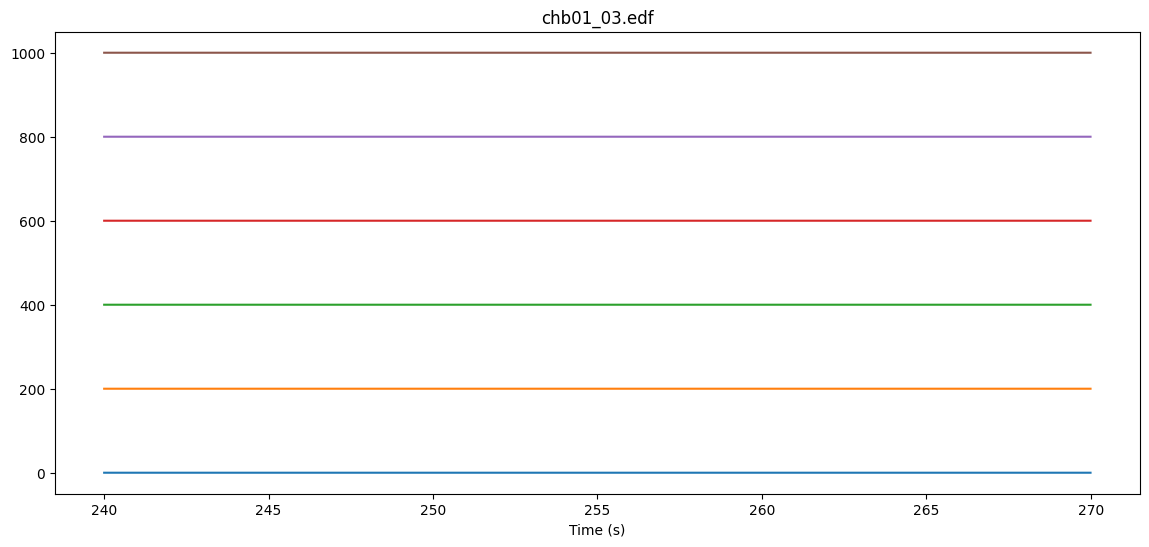

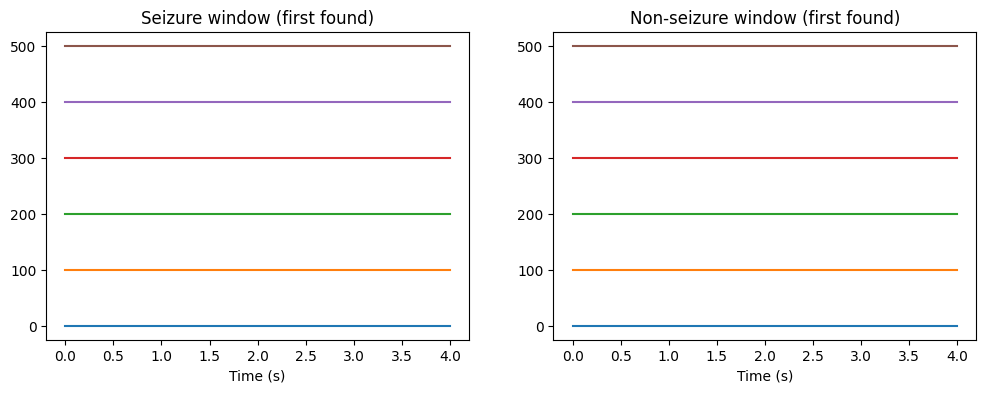

In [11]:
# plot raw around seizure for chb01_03
plot_raw_segment(os.path.join(base_dir,'chb01','chb01_03.edf'), start_s=240, dur_s=30, channels=6)

# plot one seizure window and one interictal window
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Seizure window (first found)")
s_idx = np.where(y==1)[0][0]
w = X[s_idx]  # (timesteps, channels)
for c in range(min(6, w.shape[1])):
    plt.plot(np.arange(w.shape[0])/fs, w[:,c] + c*100)
plt.xlabel("Time (s)")

plt.subplot(1,2,2)
plt.title("Non-seizure window (first found)")
ns_idx = np.where(y==0)[0][0]
w2 = X[ns_idx]
for c in range(min(6, w2.shape[1])):
    plt.plot(np.arange(w2.shape[0])/fs, w2[:,c] + c*100)
plt.xlabel("Time (s)")
plt.show()


#Plot with Mne

Using matplotlib as 2D backend.


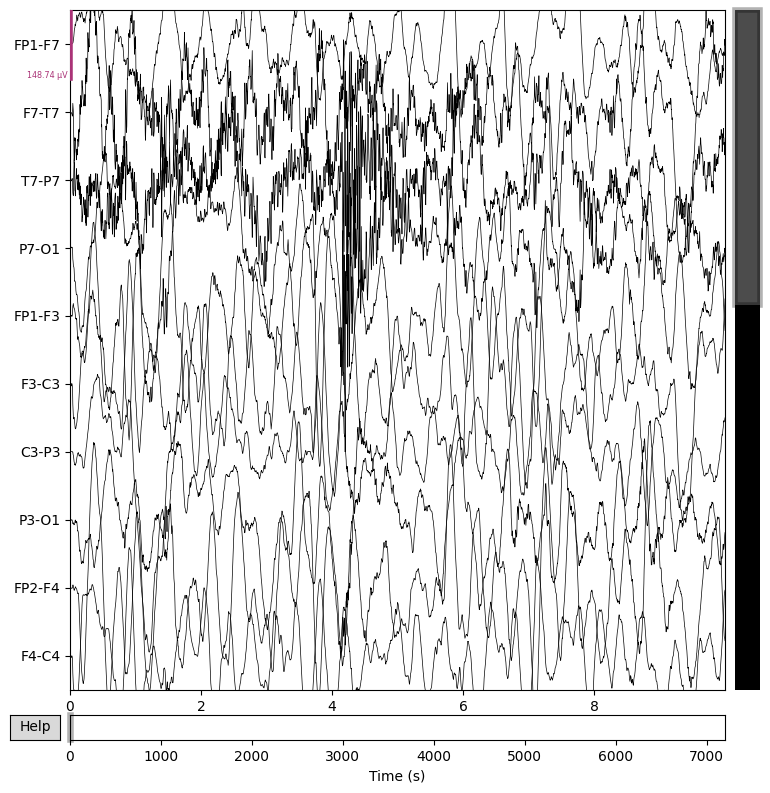

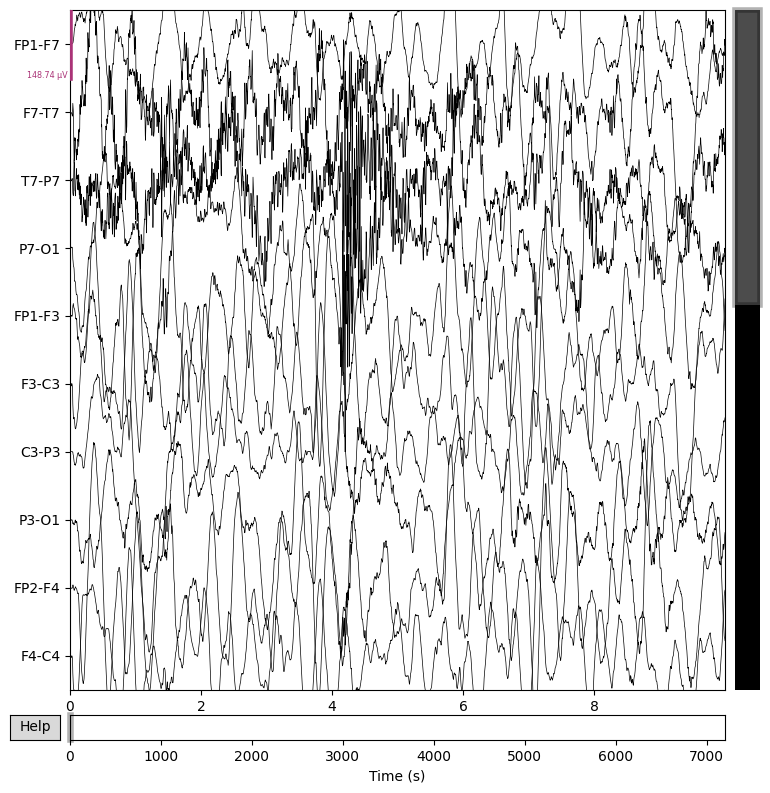

In [12]:
raw.plot(n_channels=10, duration=10, scalings='auto', title='EEG Plot', show=True)


# Highlight seizure segment

/tmp/ipython-input-1137430574.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path_to_plot, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


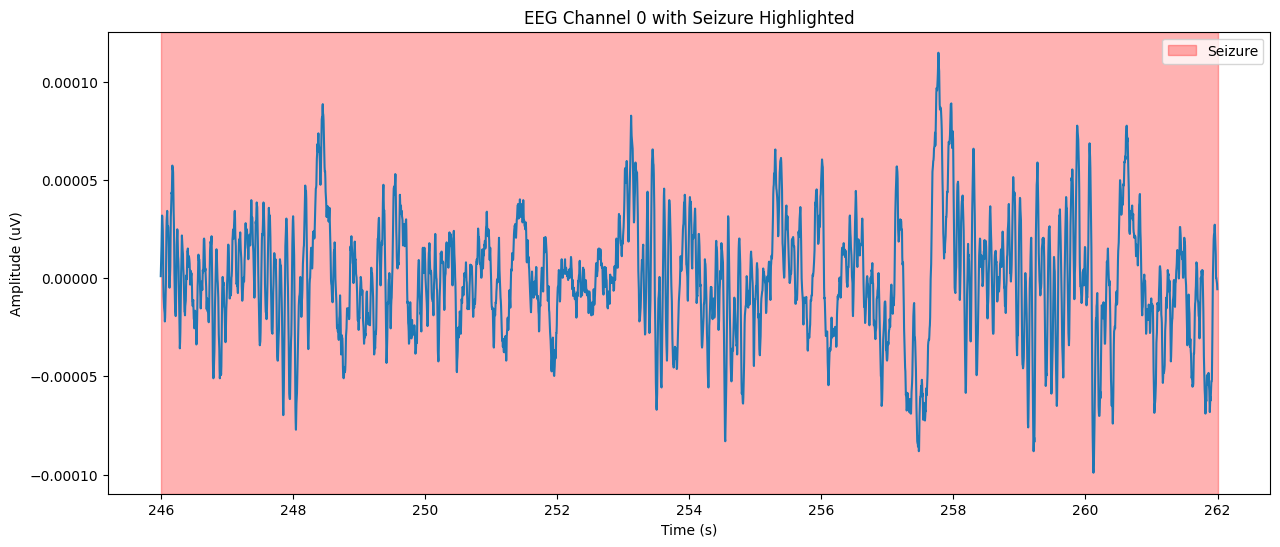

In [14]:
# Example: chb01_03 seizure from 246s to 262s
start_s, end_s = 246, 262
start_idx = int(start_s * 256)
end_idx = int(end_s * 256)

# Load the specific EDF file and extract data and times
edf_path_to_plot = os.path.join(base_dir,'chb01','chb01_03.edf')
raw = mne.io.read_raw_edf(edf_path_to_plot, preload=True, verbose=False)
raw.pick_types(eeg=True)
data = raw.get_data()
times = raw.times

plt.figure(figsize=(15,6))
plt.plot(times[start_idx:end_idx], data[0, start_idx:end_idx])  # first channel
plt.axvspan(start_s, end_s, color='red', alpha=0.3, label='Seizure')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('EEG Channel 0 with Seizure Highlighted')
plt.legend()
plt.show()